In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-12-05-09-47-28-573908


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories
              
env_id = "SpaceInvadersNoFrameskip-v4"
env_type = "atari"
env_name = "spaceinvaders"
reward_net_path = "spaceinvaders_novice_reward_all_sorted.params"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, 'atari', 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecFrameStack(env, 4)
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

/home/dsbrown/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    #print(obs_highs)
    #print(obs_lows)
    #return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0
    return obs / 255.0


In [4]:
#generate some trajectories for inspecting learned reward
checkpoint_min = 100
checkpoint_max = 3200
checkpoint_step = 200
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 1000:
        checkpoints.append('00' + str(i))
    elif i < 10000:
        checkpoints.append('0' + str(i))
print(checkpoints)

['00100', '00300', '00500', '00700', '00900', '01100', '01300', '01500', '01700', '01900', '02100', '02300', '02500', '02700', '02900', '03100', '03300']


In [5]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/" + env_name + "/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 1
    for i in range(episode_count):
        done = False
        traj = []
        r = 0
        
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(normalize_state(ob))
            steps += 1
            acc_reward += r[0]
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
        print("traj length", len(traj))
        print("demo length", len(demonstrations))
        if acc_reward not in learning_returns:
            demonstrations.append(traj)
            learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00100, steps: 524, return: 175.0
traj length 524
demo length 0
checkpoint: 00300, steps: 760, return: 415.0
traj length 760
demo length 1
checkpoint: 00500, steps: 930, return: 570.0
traj length 930
demo length 2
checkpoint: 00700, steps: 723, return: 580.0
traj length 723
demo length 3
checkpoint: 00900, steps: 1300, return: 810.0
traj length 1300
demo length 4
checkpoint: 01100, steps: 862, return: 545.0
traj length 862
demo length 5
checkpoint: 01300, steps: 970, return: 720.0
traj length 970
demo length 6
checkpoint: 01500, steps: 649, return: 485.0
traj length 649
demo length 7
checkpoint: 01700, steps: 871, return: 740.0
traj length 871
demo length 8
checkpoint: 01900, steps: 748, return: 600.0
traj length 748
demo length 9
checkpoint: 02100, steps: 1147, return: 520.0
traj length 1147
demo length 10
checkpoint: 02300, steps: 1651, return: 1435.0
traj length 1651
demo length 11
checkpoint: 02500, steps: 773, return: 600.0
traj length 773
demo length 12
checkpoint: 027

Let's plot the returns to see if they are roughly monotonically increasing.

15
15
[175.0, 415.0, 570.0, 580.0, 810.0, 545.0, 720.0, 485.0, 740.0, 600.0, 520.0, 1435.0, 1430.0, 1125.0, 575.0]
[175.0, 415.0, 485.0, 520.0, 545.0, 570.0, 575.0, 580.0, 600.0, 720.0, 740.0, 810.0, 1125.0, 1430.0, 1435.0]


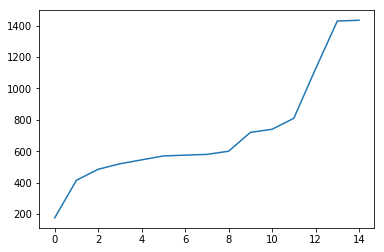

In [6]:
print(len(learning_returns))
print(len(demonstrations))
print([a[0] for a in zip(learning_returns, demonstrations)])
#cheat and sort them to see if it helps learning
sorted_demos = [x for _, x in sorted(zip(learning_returns,demonstrations), key=lambda pair: pair[0])]

sorted_returns = sorted(learning_returns)
print(sorted_returns)
plt.plot(sorted_returns)

Let's recreate the network that we previously learned.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 16, 7, stride=3)
        self.conv2 = nn.Conv2d(16, 16, 5, stride=2)
        self.conv3 = nn.Conv2d(16, 16, 3, stride=1)
        self.conv4 = nn.Conv2d(16, 16, 3, stride=1)
        self.fc1 = nn.Linear(1936, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2) #get into NCHW format
            #compute forward pass of reward network
            x = F.leaky_relu(self.conv1(x))
            x = F.leaky_relu(self.conv2(x))
            x = x.view(-1, 1936)
            x = F.leaky_relu(self.fc1(x))
            r = torch.sigmoid(self.fc2(x)) #clip reward?
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 8, 8, stride=4)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2)
        self.fc1 = nn.Linear(9*9*16, 1)
        #self.fc2 = nn.Linear(256, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(-1, 9*9*16)
            r = torch.tanh(self.fc1(x))
            
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Load previously learned network on space invaders demonstrations

In [9]:
reward = Net()
reward.load_state_dict(torch.load(reward_net_path))
reward.to(device)


Net(
  (conv1): Conv2d(4, 16, kernel_size=(7, 7), stride=(3, 3))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

See what predicted returns look like compared to actual

In [10]:
with torch.no_grad():
    pred_returns = [reward.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in sorted_demos]
for i, p in enumerate(pred_returns):
    print(i,p,sorted_returns[i])

0 0.2888616919517517 175.0
1 1.4108470678329468 415.0
2 1.824609398841858 485.0
3 7.346284866333008 520.0
4 3.534708261489868 545.0
5 4.0045623779296875 570.0
6 4.724949836730957 575.0
7 3.7648632526397705 580.0
8 4.058684349060059 600.0
9 3.430169105529785 720.0
10 5.191906929016113 740.0
11 6.825207710266113 810.0
12 6.048191070556641 1125.0
13 8.653353691101074 1430.0
14 11.036511421203613 1435.0


In [11]:
def convert_range(x,minimum, maximum,a,b):
    return (x - minimum)/(maximum - minimum) * (b - a) + a


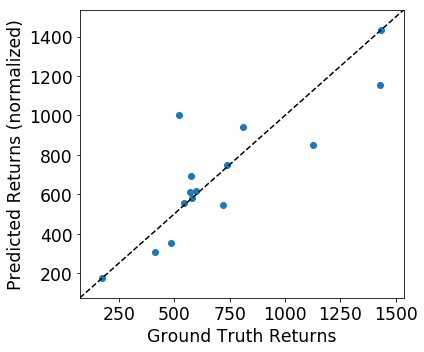

In [12]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
buffer_room = 100
pylab.rcParams.update(params)
plt.plot(sorted_returns, [convert_range(p,max(pred_returns), min(pred_returns),max(sorted_returns), min(sorted_returns)) for p in pred_returns],'o')
plt.plot([min(sorted_returns)-buffer_room, max(sorted_returns)+buffer_room],[min(sorted_returns)-buffer_room, max(sorted_returns)+buffer_room],'k--')
plt.axis([min(sorted_returns)-buffer_room,max(sorted_returns)+buffer_room,min(sorted_returns)-buffer_room,max(sorted_returns)+buffer_room])
plt.xlabel("Ground Truth Returns")
plt.ylabel("Predicted Returns (normalized)")
plt.tight_layout()
plt.savefig(env_name + "_gt_vs_pred_rewards.png")

#plt.axis('square')



In [13]:
print(learning_returns)
returns_to_plot = [175, 575, 810, 1435]
demos_to_plot = []
for r in returns_to_plot:
    for i,d in enumerate(demonstrations):
        if learning_returns[i] == r:
            print(learning_returns[i])
            demos_to_plot.append(d)
            break


[175.0, 415.0, 570.0, 580.0, 810.0, 545.0, 720.0, 485.0, 740.0, 600.0, 520.0, 1435.0, 1430.0, 1125.0, 575.0]
175.0
575.0
810.0
1435.0


In [14]:
print(returns_to_plot)

[175, 575, 810, 1435]


0
1
2
3


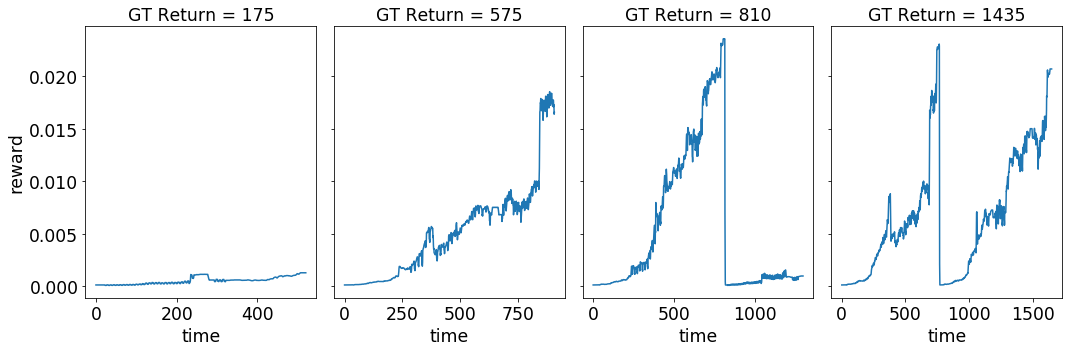

In [15]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
#print out the actual time series of rewards predicted by nnet for each trajectory.
cnt = 0
with torch.no_grad():
    for d in demos_to_plot:
        rewards = []
        print(cnt)
        cnt += 1
        for s in d:
            r = reward.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            #print(r)
            rewards.append(r)
        if cnt == 1:
            ax = plt.subplot(1,4,cnt)
            plt.ylabel("reward")
        else:
            ax2 = plt.subplot(1,4,cnt, sharey=ax)
            plt.setp(ax2.get_yticklabels(), visible=False)
        plt.plot(rewards[2:-1])
        plt.xlabel("time")
        
        plt.title("GT Return = {}".format(returns_to_plot[cnt-1]))
        
#plt.savefig("learned_mcar_return.png")
plt.tight_layout()
plt.savefig(env_name + "RewardPlots.png")

plt.show()


In [32]:
#check if loss without training matches what I had before
def loss_reward(reward_network, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j and give classification label to later one
        j = np.random.randint(len(trajectories)) 
        i = np.random.randint(len(trajectories))
        while(i == j):
            i = np.random.randint(len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        if i > j:
            labels = np.array([[0]])
        else:
            labels = np.array([[1]])
            
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        
        #zero out gradient
        #optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 50 == 49:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 50)
            cum_loss = 0.0
    print("finished training")

In [34]:
loss_reward(reward, sorted_demos[:8], 100)

49 0.064114990234375
99 0.07234839439392089
finished training


In [35]:
#Hmm looks pretty good.

In [ ]:
min_reward = 10 
max_reward = -10
cnt = 0
with torch.no_grad():
    for d in sorted_demos:
        print(cnt)
        
        for i,s in enumerate(d[2:-1]):
            r = reward.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            if r < min_reward:
                min_reward = r
                min_frame = s
                min_frame_i = i+2
                min_frame_demo = cnt
            elif r > max_reward:
                max_reward = r
                max_frame = s
                max_frame_i = i+2
                max_frame_demo = cnt
        cnt += 1
        

In [20]:
print("min reward", min_reward, "in demo", min_frame_demo)
print("max reward", max_reward, "in demo", max_frame_demo)

min reward 6.592774298042059e-05 in demo 0
max reward 0.02359958551824093 in demo 11


806


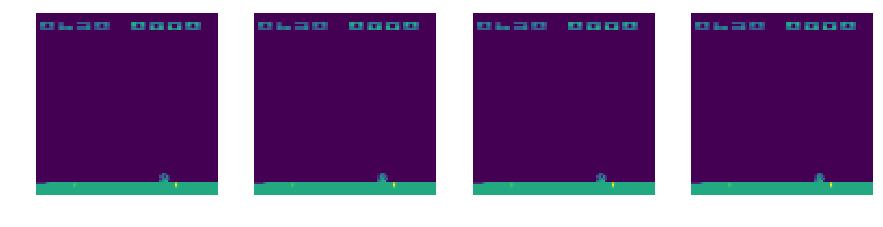

In [17]:
print(max_frame_i)
for cnt in range(4):
    plt.subplot(1,4,cnt+1)
    plt.imshow(max_frame[0][:,:,cnt])
    plt.axis('off')
plt.savefig(env_name + "_maxreward_obs.png")
#plt.figure(2)
#plt.imshow(demonstrations[0][max_frame_i-5][0][:,:,0])
#plt.show()

35


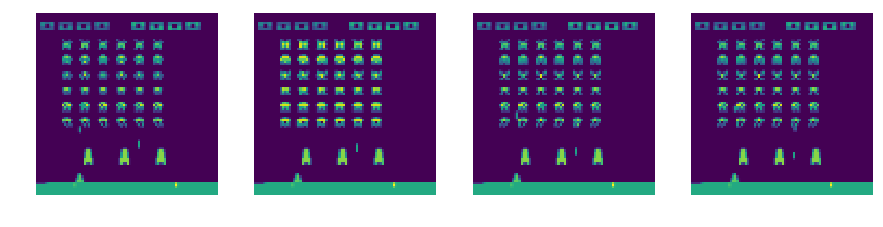

In [18]:
print(min_frame_i)
for cnt in range(4):
    plt.subplot(1,4,cnt+1)
    plt.imshow(min_frame[0][:,:,cnt])
    plt.axis('off')
plt.savefig(env_name + "_minreward_obs.png")
#plt.figure(2)
#plt.imshow(demonstrations[0][max_frame_i-5][0][:,:,0])
#plt.show()